In [1]:
%run ../_preamble.ipynb
from _work.src.modules import AutoEncoder, train_model, plot_metrics, plot_tensor
from _work.src.modules.utils import save_metrics, load_metrics
from _work.src.data import small_dataloader as dataloader
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch

In [2]:
# %%bash
# cd ..
# cd runs
# ls
# rm -rf ./*
# echo '^removed'

1_under_25_1501_2_0_1_0.1_False
1_under_25_1501_2_0_1_1_False
1_under_5_500_2_0_1_0.25_True
1_under_5_500_2_0_1_0.5_False
1_under_5_500_2_0_1_0.5_True
^removed


In [2]:
def make_runs(
    name="test",
    n_runs=10,
    n_epochs=500,
    hidden_size=2,
    batch_norm=False,
    dropout=0,
    lr=1e-2,
    noise_mean=None,
    noise_stdev=None,
    noise_multiplier=None,
    **kwargs,
):
    # m = []

    for i in range(n_runs):
        metrics = train_model(
            model := AutoEncoder(
                sizes=[dataloader.dataset.NUM_ATTRIBUTES, hidden_size], batch_norm=batch_norm, dropout=dropout
            ),
            optimizer := torch.optim.AdamW(model.parameters(), lr=lr),
            loss_fn := torch.nn.MSELoss(reduction="sum"),
            dataloader,
            epochs=n_epochs,
            noise_mean=noise_mean,
            noise_stdev=noise_stdev,
            noise_multiplier=noise_multiplier,
            **kwargs,
        )
        save_metrics(metrics, f"{name}/{i}")
        # m.append(metrics[0])

    metrics = load_metrics(name)
    return metrics
    # return m


def plot_loss(metrics):
    x = pd.DataFrame()
    for i, losses in enumerate([m.losses for m in metrics]):
        for type in ['train', 'test']:
            new = pd.DataFrame(data=losses[type], columns=['loss'])
            new['type'] = [type] * len(new)
            new['run'] = [i] * len(new)

            x = pd.concat([x, new])

    x = x.reset_index(level=0).rename(columns={ 'index': 'epoch' })

    sns.lineplot(x="epoch", y="loss", hue='type', data=x)
    plt.xticks([*range(0, 150 + 1, 25)])
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles=handles, labels=[x.capitalize() for x in labels])


def plot_indiv_loss(metrics):
    x = pd.DataFrame()
    for i, predictions in enumerate([m.predictions for m in metrics]):        
        new = predictions[['epoch', 'loss']].copy()
        new['item'] = new.index
        new['run'] = [i] * len(new)

        x = pd.concat([x, new])

    palette = {
        'Oak': '#B0E65A',
        'Pine': '#75993C',
        'Daisy': '#FEB756',
        'Rose': '#E6634E',
        'Salmon': '#9194E3',
        'Sunfish': '#8BCBD9',
        'Canary': '#FFD92F',
        'Robin': '#FF8C9A',
    }
    sns.lineplot(data=x, x="epoch", y="loss", hue='item', palette=palette)
    plt.xticks([*range(0, 150 + 1, 25)])
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    order = [*map(lambda x: x[0], sorted(enumerate(labels), key=lambda x: [*palette.keys()].index(x[1])))]
    handles = [*map(lambda x: x[1], sorted(enumerate(handles), key=lambda x: order.index(x[0])))]
    labels = [*map(lambda x: x[1], sorted(enumerate(labels), key=lambda x: order.index(x[0])))]
    plt.legend(handles=handles, labels=[x.capitalize() for x in labels])
    # plt.xlim([1250, 1500])
    # plt.ylim([0.1, 0.7])

# plot_indiv_loss(metrics)

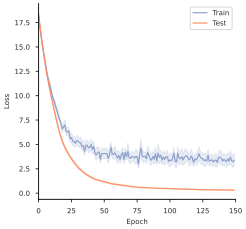

In [17]:
# params = {
#     'n_runs': 25,
#     'n_epochs': 150,
#     'hidden_size': 32,
#     'noise_mean': 0,
#     'noise_stdev': 1,
#     'noise_multiplier': 0.5,
#     'batch_norm': False,
#     'l1_lambda': 0.0005,
# }

# name = f"1_under_{'_'.join([str(x) for x in params.values()])}"

# metrics = make_runs(name=name, **params)
# plot_loss(metrics);
# plt.savefig("../plots/1_over_32");

In [3]:
metrics = load_metrics('1_over_25_150_32_0_1_0.5_False_0.0005')

In [3]:
def plot_svd(metrics):
    x = pd.DataFrame()
    for i, predictions in enumerate([m.predictions for m in metrics]):        
        row = pd.DataFrame()
        for epoch in predictions['epoch'].unique():
            df = predictions[predictions['epoch'] == epoch].drop(columns=['accuracy', 'loss', 'epoch'])
            u, s, vT = np.linalg.svd(df.transpose(), full_matrices=False)
            entry = pd.DataFrame(s, columns=['sing'])
            entry['epoch'] = epoch
            entry['idx'] = entry.index
            row = pd.concat([row, entry])

        row['run'] = [i] * len(row)
        x = pd.concat([x, row]) 

    palette = sns.color_palette("viridis_r", n_colors=8)
    sns.lineplot(data=x, x='epoch', y='sing', hue='idx', palette=palette)
    plt.xlabel("Epoch")
    plt.ylabel("Singular value")
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(
        handles,
        [f"$s_{i}$" for i in range(8)],
        loc='upper right',
    )
    plt.xticks(range(0, 1500 + 1, 250))

# plot_svd(metrics);
# plt.savefig('../plots/1_over_32_singular_magma');

In [5]:
metrics2 = load_metrics('1_under_25_1500_2_0_1_0.5_False_0.0005')

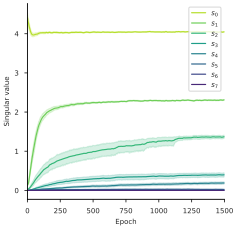

In [6]:
plot_svd(metrics2);
plt.savefig('../plots/1_under_2_singular_viridis');

In [4]:
from collections import defaultdict
from _work.src.modules.replay import iterate
from _work.src.modules.utils import get_closest_item
from scipy.optimize import minimize
from scipy import interpolate
from scipy.spatial.distance import cdist
from sklearn.preprocessing import Normalizer

def transition_matrix(model, dataloader, mean=0, stdev=1, multiplier=1, runs=100, steps=10):
    transitions = defaultdict(lambda: defaultdict(lambda: 0))
    for item_a in dataloader.dataset.df.index:
        for item_b in dataloader.dataset.df.index:
            transitions[item_a][item_b] = 0

    for i, batch in enumerate(dataloader.dataset):
        origin = dataloader.dataset.df.index[i]
        item = batch["y"]

        states, _ = iterate(
            model,
            initial_state=item,
            mean=mean,
            stdev=stdev,
            multiplier=multiplier,
            runs=runs,
            steps=steps,
        )

        for final_state in states[:, 1:, :].reshape(-1, states.shape[-1]):
            closest_item, _ = get_closest_item(dataloader.dataset.df, final_state)
            transitions[origin][closest_item] += 1

    transitions = {k: dict(v) for k, v in transitions.items()}
    matrix = (
        pd.DataFrame(transitions)
        .transpose()
        .reindex(index=dataloader.dataset.df.index, columns=dataloader.dataset.df.index)
        .fillna(0)
        .astype(int)
    )
    matrix = matrix.divide(matrix.sum(axis=1), axis=0)
    return matrix


def find_optimal_noise(model, dataloader):
    df = dataloader.dataset.df
    dists = cdist(df, df, metric="correlation")
    dists_normed = Normalizer().fit_transform(dists)
    sims_normed = torch.tensor(1 - dists_normed)

    def f(params):
        # mean, stdev, multiplier = params
        mean, stdev = params
        multiplier = 0.1
        matrix = transition_matrix(model, dataloader, runs=10, steps=10, mean=mean, stdev=stdev, multiplier=multiplier)
        matrix = torch.tensor(matrix.values)
        diff = matrix - sims_normed
        return torch.sum(diff * diff).item()
    
    # initial_guess = [0, 1, 0.1]
    initial_guess = [0, 1]
    result = minimize(f, initial_guess, method='powell')
    print(result)

# find_optimal_noise(model, dataloader)

In [5]:
_ = train_model(
    model := AutoEncoder(
        sizes=[dataloader.dataset.NUM_ATTRIBUTES, 32],
        batch_norm=False,
        dropout=0,
    ),
    optimizer := torch.optim.AdamW(model.parameters(), lr=1e-2),
    loss_fn := torch.nn.MSELoss(reduction="sum"),
    dataloader,
    epochs=150,
    noise_mean=0,
    noise_stdev=1,
    noise_multiplier=0.5,
)

df = dataloader.dataset.df
dists = cdist(df, df, metric="correlation")
dists_normed = Normalizer().fit_transform(dists)
sims_normed = torch.tensor(1 - dists_normed)

means = np.linspace(0, 3, num=50)
stdevs = np.linspace(0, 3, num=50)
x, y = np.meshgrid(means, stdevs)

def fun(mean, stdev):
    matrix = transition_matrix(model, dataloader, runs=10, steps=10, mean=mean, stdev=stdev, multiplier=0.5)
    matrix = torch.tensor(matrix.values)
    diff = matrix - sims_normed
    return torch.sum(diff * diff).item()

z = np.array([fun(a, b) for a, b in zip(x.ravel(), y.ravel())])
z = z.reshape(x.shape)

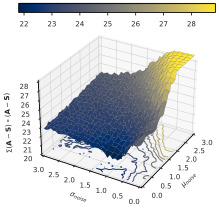

In [21]:
from matplotlib import gridspec
from scipy import interpolate
from matplotlib import cm

def plot_noise_surf(X, Y, Z, interp=True):
    if interp:
        Xnew, Ynew = np.mgrid[np.min(X):np.max(X):40j, np.min(Y):np.max(Y):40j]
        rbfi = interpolate.Rbf(X, Y, Z)
        Znew = rbfi(Xnew, Ynew)
    else:
        Xnew, Ynew, Znew = X, Y, Z

    fig = plt.figure()
    gs = gridspec.GridSpec(2, 1, height_ratios=[0.05, 1], hspace=0.1)

    cmap = 'cividis'
    ax = fig.add_subplot(gs[1], projection='3d')
    ax.view_init(30, 30)
    ax.plot_surface(
        Xnew,
        Ynew,
        Znew,
        cmap=cmap,
        rstride=2,
        cstride=2,
        alpha=1,
        antialiased=False,
        shade=True,
        linewidth=0.1,
        edgecolor=(0.1, 0.1, 0.1),
    )
    ax.set_xlabel('$\mu_{noise}$', labelpad=-3)
    ax.set_ylabel('$\sigma_{noise}$', labelpad=-3)
    ax.set_zlabel('$\Sigma (\mathbf{A} - \mathbf{S}) \circ (\mathbf{A} - \mathbf{S})$', labelpad=-3)

    ax.contour(Xnew, Ynew, Znew, 8, cmap=cmap, offset=20, zdir='z', linewidths=1, linestyles='solid')
    
    fig.canvas.draw()
    ax.zaxis.set_rotate_label(False)
    rot = ax.zaxis.label.get_rotation()
    rot += 180
    ax.zaxis.label.set_rotation(rot)

    xlabels, xticks = ax.get_xticklabels(), ax.get_xticks()
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels, rotation=0, va='center', ha='left')

    ax.xaxis.set_tick_params(which='both', pad=0)
    ax.yaxis.set_tick_params(which='both', pad=0)
    ax.zaxis.set_tick_params(which='both', pad=0)
    # ax.xaxis.set_ticks([0, 1, 2, 3])
    # ax.yaxis.set_ticks([0, 1, 2, 3])
    # ax.zaxis.set_ticks([22, 23,24,25,26,27,28])

    ax.invert_xaxis()
    ax.set_ylim([3, 0])
    ax.set_zlim([20, 28])

    cax = fig.add_subplot(gs[0])

    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array(Znew)
    fig.colorbar(mappable, cax=cax, orientation="horizontal")

# X, Y = np.mgrid[-1:1:20j, -1:1:20j]
# Z = (X + Y) * np.exp(-6.0 * (X * X + Y * Y)) + np.random.rand(X.shape[0])

plot_noise_surf(x, y, z, interp=True)
# plt.tight_layout()
# plt.savefig('../plots/1_over_32_noise_surf_cividis')